# **DATA3888 Project: Optiver**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
from glob import glob
from sklearn.decomposition import PCA
from sklearn.preprocessing  import StandardScaler
import os
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import matplotlib.pyplot as plt

In [2]:
csv_files = sorted(glob("Data/individual_book_train/*.csv"))

ldf = pl.scan_csv(
    csv_files,
    schema_overrides={         
        'time_id': pl.Int64,
        'seconds_in_bucket': pl.Int64,
        'bid_price1': pl.Float64,
        'ask_price1': pl.Float64,
        'bid_price2': pl.Float64,
        'ask_price2': pl.Float64,
        'bid_size1': pl.Int64,
        'ask_size1': pl.Int64,
        'bid_size2': pl.Int64,
        'ask_size2': pl.Int64,
        'stock_id': pl.Int64,
    },
    infer_schema_length=0
)

# df = ldf.collect()  
# df.write_parquet("Data/Combined_book_train.parquet", compression="snappy")

In [2]:
df = pl.read_parquet(
    "Data/Combined_book_train.parquet",
    use_pyarrow=True  
)

In [3]:
df = df.to_pandas()

In [10]:
df.shape[0]/857864

194.9648067758992

In [6]:
window_size = 300   
df['window_start'] = (df['seconds_in_bucket'] // window_size) * window_size

agg = (
    df
    .groupby(['stock_id', 'time_id', 'window_start'], as_index=False)
    .agg({
        'bid_price1':  'mean',
        'ask_price1':  'mean',
        'bid_price2':  'mean',
        'ask_price2':  'mean',
        'bid_size1':   'sum',
        'ask_size1':   'sum',
        'bid_size2':   'sum',
        'ask_size2':   'sum',
    })
)

agg['seconds_in_bucket'] = agg['window_start']

In [8]:
agg.shape[0]

857864

In [26]:
agg["stock_id"].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  46,  47,  48,  50,  51,  52,  53,  55,  56,  58,
        59,  60,  61,  62,  63,  64,  66,  67,  68,  69,  70,  72,  73,
        74,  75,  76,  77,  78,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       118, 119, 120, 122, 123, 124, 125, 126])

In [27]:
summary = (agg
    .groupby('stock_id')
    .agg(
        avg_bid_size1   = ('bid_size1', 'mean'),
        avg_ask_size1   = ('ask_size1', 'mean'),
        avg_bid_size2   = ('bid_size2', 'mean'),
        avg_ask_size2   = ('ask_size2', 'mean'),
        avg_bid_price1  = ('bid_price1','mean'),
        avg_ask_price1  = ('ask_price1','mean'),
    )
)

summary['spread']    = summary['avg_ask_price1'] - summary['avg_bid_price1']
summary['depth']     = summary[['avg_bid_size1','avg_ask_size1','avg_bid_size2','avg_ask_size2']].mean(axis=1)
summary['liq_score'] = summary['depth'] / summary['spread']

k = 30
top_liquid = summary.nlargest(k, 'liq_score').index.tolist()
print(top_liquid)

[32, 31, 77, 43, 29, 41, 108, 111, 47, 124, 46, 35, 119, 44, 125, 69, 21, 13, 86, 99, 63, 123, 14, 10, 120, 85, 105, 89, 74, 50]


In [ ]:
df1 = agg.copy()

df1['mid'] = (df1['bid_price1'] + df1['ask_price1']) / 2
df1 = df1.sort_values(['stock_id','time_id','seconds_in_bucket'])
df1['mid_prev'] = df1.groupby('stock_id')['mid'].shift(1)
df1['ret']     = np.log(df1['mid'] / df1['mid_prev'])

vol = df1.groupby('stock_id')['ret'].var().rename('ret_var')

threshold = vol.quantile(0.75)
high_vol = vol[vol > threshold].index.tolist()
print(high_vol)

[1, 3, 6, 8, 9, 11, 16, 18, 27, 31, 33, 44, 56, 62, 63, 74, 75, 80, 81, 83, 88, 89, 90, 94, 97, 100, 112, 124]


In [ ]:
summary = summary.join(vol)

X = StandardScaler().fit_transform(summary)
pca = PCA(n_components=2).fit(X)
scores = pca.transform(X)   

pc1_scores = pd.Series(np.abs(scores[:,0]), index=summary.index)
top_pca = pc1_scores.nlargest(30).index.tolist()
print(top_pca)

[31, 32, 77, 108, 41, 43, 29, 111, 47, 35, 37, 33, 98, 5, 103, 112, 18, 75, 4, 27, 30, 0, 88, 16, 62, 116, 113, 110, 126, 90]


In [30]:
main_df = df[df['stock_id'].isin(top_pca)]

In [31]:
main_df

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,window_start
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0,0
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0,0
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0,0
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0,0
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
165425983,32767,575,1.000330,1.001253,1.000308,1.001319,90,76,23,153,98,300
165425984,32767,577,1.000330,1.001253,1.000308,1.001319,90,76,2,153,98,300
165425985,32767,581,1.000330,1.001253,1.000308,1.001319,90,91,2,153,98,300
165425986,32767,591,1.000330,1.001253,1.000308,1.001319,90,91,2,166,98,300


In [ ]:
def make_main_df(csvPath: str, keepData: bool, window_size: int) -> pd.DataFrame:

    # Create combined Parquet
    csv_files = sorted(glob.glob(csvPath))
    ldf = pl.scan_csv(
        csv_files,
        schema_overrides={         
            'time_id': pl.Int64,
            'seconds_in_bucket': pl.Int64,
            'bid_price1': pl.Float64,
            'ask_price1': pl.Float64,
            'bid_price2': pl.Float64,
            'ask_price2': pl.Float64,
            'bid_size1': pl.Int64,
            'ask_size1': pl.Int64,
            'bid_size2': pl.Int64,
            'ask_size2': pl.Int64,
            'stock_id': pl.Int64,
        },
        infer_schema_length=0
    )
    df = ldf.collect()  
    df.write_parquet("combined_stock_data.parquet", compression="snappy")

    # Read combined Parquet
    df = pl.read_parquet(
        "combined_stock_data.parquet",
        use_pyarrow=True  
    )
    df = df.to_pandas()
    if not keepData:
        os.remove("combined_stock_data.parquet")

    # Reduce Information 
    df['window_start'] = (df['seconds_in_bucket'] // window_size) * window_size
    agg = (
        df
        .groupby(['stock_id', 'time_id', 'window_start'], as_index=False)
        .agg({
            'bid_price1':  'mean',
            'ask_price1':  'mean',
            'bid_price2':  'mean',
            'ask_price2':  'mean',
            'bid_size1':   'sum',
            'ask_size1':   'sum',
            'bid_size2':   'sum',
            'ask_size2':   'sum',
        })
    )
    agg['seconds_in_bucket'] = agg['window_start']

    # Finding Best Stock_id
    summary = (agg
        .groupby('stock_id')
        .agg(
            avg_bid_size1   = ('bid_size1', 'mean'),
            avg_ask_size1   = ('ask_size1', 'mean'),
            avg_bid_size2   = ('bid_size2', 'mean'),
            avg_ask_size2   = ('ask_size2', 'mean'),
            avg_bid_price1  = ('bid_price1','mean'),
            avg_ask_price1  = ('ask_price1','mean'),
        )
    )
    summary['spread']    = summary['avg_ask_price1'] - summary['avg_bid_price1']
    summary['depth']     = summary[['avg_bid_size1','avg_ask_size1','avg_bid_size2','avg_ask_size2']].mean(axis=1)
    summary['liq_score'] = summary['depth'] / summary['spread']

    df1 = agg.copy()
    df1['mid'] = (df1['bid_price1'] + df1['ask_price1']) / 2
    df1 = df1.sort_values(['stock_id','time_id','seconds_in_bucket'])
    df1['mid_prev'] = df1.groupby('stock_id')['mid'].shift(1)
    df1['ret']     = np.log(df1['mid'] / df1['mid_prev'])
    vol = df1.groupby('stock_id')['ret'].var().rename('ret_var')

    summary = summary.join(vol)
    X = StandardScaler().fit_transform(summary)
    pca = PCA(n_components=2).fit(X)
    scores = pca.transform(X)   
    pc1_scores = pd.Series(np.abs(scores[:,0]), index=summary.index)
    top_pca = pc1_scores.nlargest(30).index.tolist()

    return df[df['stock_id'].isin(top_pca)]

In [ ]:
mainDF = make_main_df("Data/individual_book_train/*.csv", False, 300)

In [ ]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:

    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread'] = df['ask_price1'] - df['bid_price1']
    df['rel_spread'] = df['spread'] / df['mid_price']
    df['imbalance'] = (df['bid_size1'] - df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['book_pressure'] = ((df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])) / (df['bid_size1'] + df['bid_size2'] + df['ask_size1'] + df['ask_size2'])
    df['microprice'] = ((df['ask_price1'] * df['bid_size1'] + df['bid_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1']))
    df['normalized_spread'] = df['spread'] / df['mid_price']
    df['OBI_L2'] = ((df['bid_size1'] + df['bid_size2']) / (df['bid_size1'] + df['bid_size2'] + df['ask_size1'] + df['ask_size2']))

    sizes = df[['bid_size1', 'bid_size2', 'ask_size1', 'ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p = np.divide(sizes, total, where=total != 0)
    entropy = -np.nansum(np.where(p > 0, p * np.log(p, where=p > 0), 0), axis=1)
    df['LOB_entropy'] = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)

    df['log_return'] = df.groupby('time_id')['mid_price'].transform(lambda x: np.log(x / x.shift(1)))

    df['realized_volatility'] = df.groupby('time_id')['log_return'].transform(lambda x: np.sqrt(x.pow(2).rolling(window=30, min_periods=1).sum()))

    df['bipower_var'] = df.groupby('time_id')['log_return'].transform(
        lambda x: (
            x.abs().rolling(2).apply(lambda r: r[0] * r[1], raw=True)
            .rolling(30, min_periods=1).mean()
        )
    )
    
    df['rolling_integrated_variance'] = df.groupby('time_id')['log_return'].transform(
        lambda x: x.pow(2).rolling(window=30, min_periods=1).sum()
    )

    return df.dropna()

In [ ]:
df = make_features(mainDF)

In [ ]:
stock_ids = df['stock_id'].unique()
time_ids = df['time_id'].unique()

full_index = pd.MultiIndex.from_product(
    [stock_ids, time_ids, range(600)],
    names=['stock_id', 'time_id', 'seconds_in_bucket']
)

df = (
    df
    .set_index(['stock_id', 'time_id', 'seconds_in_bucket'])
    .reindex(full_index)
)

columns_to_fill = [col for col in df.columns if col not in ['stock_id', 'time_id', 'seconds_in_bucket']]
df[columns_to_fill] = df.groupby(level=[0, 1])[columns_to_fill].ffill()

df = df.reset_index()

In [ ]:
df.info()

In [3]:
df.dropna(inplace=True)

In [6]:
split_idx = int(len(df) * 0.8)
X = df.drop(columns=['realized_volatility'])
y = df['realized_volatility']
X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [7]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_jobs': -1,
    'boosting_type': 'gbdt',
    'verbosity': -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(period=100)
    ],
    num_boost_round=1000
)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's rmse: 0.000589185


In [8]:
y_pred = model.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"Validation RMSE: {rmse:.10f}")
print("Mean target:", y_val.mean())
print("Std of target:", y_val.std())
print("Relative RMSE:", rmse / y_val.mean())

Validation RMSE: 0.0005891847
Mean target: 0.0012567652752336997
Std of target: 0.0018385339883217377
Relative RMSE: 0.4688104199339004


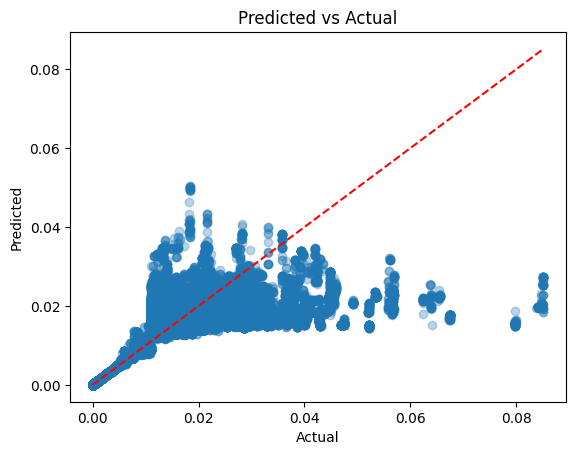

In [9]:
plt.scatter(y_val, y_pred, alpha=0.3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.show()

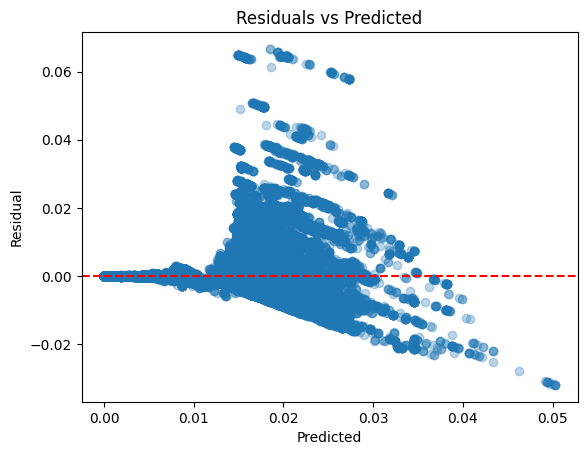

In [10]:
residuals = y_val - y_pred
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted')
plt.show()